In [1]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('my_densenet_model.h5') 


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction probabilities: [2.9694123e-04 9.9970299e-01]
The model predicts the image is cancerous.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

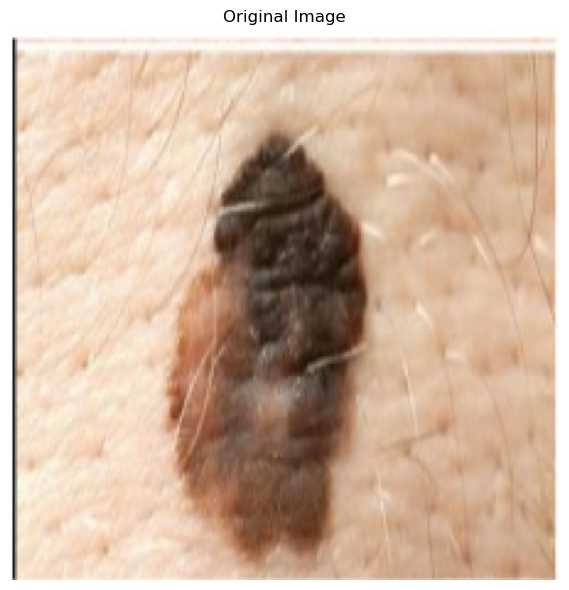

In [13]:
from lime import lime_image
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic, mark_boundaries
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('my_densenet_model.h5')

# Define a prediction function for LIME
def predict_fn(images):
    preds = model.predict(images)
    return preds

# Initialize LIME
explainer = lime_image.LimeImageExplainer()

# Load and preprocess the image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

# Predict if the image is cancerous
def predict_image(image_path):
    img_array = preprocess_image(image_path)
    preds = model.predict(img_array)
    # Assuming cancerous is class 1 and non-cancerous is class 0
    is_cancerous = preds[0][1] > 0.5
    return is_cancerous, preds

# Function to generate textual reasons based on LIME explanation
def get_textual_reasons(explanation, label):
    # Get the explanation for the given label
    temp, mask = explanation.get_image_and_mask(
        label=label,
        positive_only=True,
        num_features=5,
        hide_rest=False
    )
    
    # Get feature contributions from the explanation
    feature_importances = explanation.local_exp[label]
    
    feature_descriptions = []
    
    for i, (feature, weight) in enumerate(feature_importances):
        if weight > 0:
            feature_descriptions.append(f"Feature {i+1}: Contributes positively with a weight of {weight:.4f}. This segment may show characteristics indicative of melanoma.")
        else:
            feature_descriptions.append(f"Feature {i+1}: Contributes negatively with a weight of {weight:.4f}. This segment may not show typical features of melanoma.")
    
    # Add medical context
    medical_explanation = "Based on the features highlighted by LIME:\n"
    if np.any(mask):
        medical_explanation += "- Melanomas often present as asymmetrical lesions with irregular borders.\n"
        medical_explanation += "- Color variation within the lesion is a common sign.\n"
        medical_explanation += "- The highlighted areas correspond to these typical characteristics.\n"
    else:
        medical_explanation += "No significant melanoma features were highlighted by the model.\n"
        medical_explanation += "The model did not detect clear signs of melanoma based on the image. Further clinical evaluation is recommended.\n"

    return "\n".join(feature_descriptions) + "\n\n" + medical_explanation

# Preprocess image for segmentation
def preprocess_for_segmentation(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    return img_array

# Segment the image using SLIC (Simple Linear Iterative Clustering)
def segment_image(image):
    segments = slic(image, n_segments=100, compactness=10, sigma=1)
    return segments

# Overlay boundaries on the original image
def overlay_boundaries(image, segments):
    boundaries = mark_boundaries(image, segments, color=(1, 0, 0), mode='thick')
    return boundaries

# Main process
image_path = 'D:\sample-backend\cancerous_image.jpg'

# Check if the image is cancerous
is_cancerous, preds = predict_image(image_path)

# Display prediction probabilities
print(f"Prediction probabilities: {preds[0]}")

if is_cancerous:
    print("The model predicts the image is cancerous.")
    
    # Explain the instance
    img_array = preprocess_image(image_path)
    explanation = explainer.explain_instance(
        img_array[0],
        predict_fn,
        top_labels=2,
        hide_color=0,
        num_samples=1000
    )

    # Use the function to get textual reasons
    label = 1  # Label for cancerous class
    textual_reasons = get_textual_reasons(explanation, label)
    print(textual_reasons)

else:
    print("The model predicts the image is not cancerous.")
    print("The model did not detect significant signs of cancerous features based on the image.")

# Preprocess image for segmentation
image_for_segmentation = preprocess_for_segmentation(image_path)

# Segment the image
segments = segment_image(image_for_segmentation)

# Overlay boundaries
boundaries = overlay_boundaries(image_for_segmentation, segments)

# Display the original image with boundaries
plt.figure(figsize=(12, 6))

# Display the original image
# plt.subplot(1, 2, 1)
plt.imshow(image_for_segmentation)
plt.axis('off')
plt.title('Original Image')

# Display the image with red boundaries
# plt.subplot(1, 2, 2)
# plt.imshow(boundaries)
# plt.axis('off')
# plt.title('Image with Red Boundaries')

plt.tight_layout()
plt.show()


In [ ]:
# import tensorflow as tf
# print(tf.__version__)
# import keras
# print(keras.__version__)

2.16.1
3.2.1


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step

Step-by-Step Display:


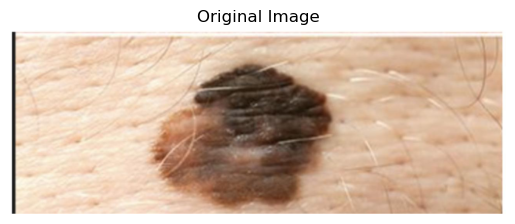

Original Image: “Here is the original skin lesion image.”


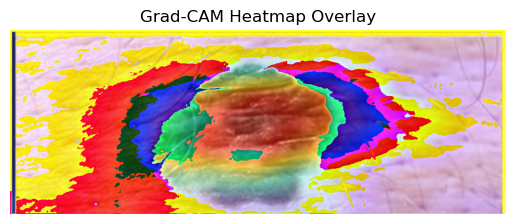

Heatmap Overlaid on Image: “The model focused on these areas (in red/yellow) to make its prediction.”
Explanation: “The model predicts this lesion as Malignant with a confidence of 99.97%. The red regions represent areas that the model believes to be most indicative of malignancy. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue.”


In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import cv2

# Load your trained model
model = load_model('my_densenet_model.h5')

# Function to preprocess image for model
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to make Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Ensure the outputs are Keras tensors
    last_conv_layer_output = model.get_layer(last_conv_layer_name).output
    model_output = model.output
    
    # Check if model_output is a list or nested structure
    if isinstance(model_output, list):
        # Flatten the list if needed
        model_output = model_output[0]

    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[last_conv_layer_output, model_output]
    )

    # Compute the gradient of the top predicted class with respect to the output feature map
    with tf.GradientTape() as tape:
        inputs = tf.cast(img_array, tf.float32)
        conv_outputs, predictions = grad_model(inputs)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)

    # Pool gradients over all axes except the channel axis
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply pooled gradients with the feature map
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



# Function to generate and display both visual and textual explanations
def step_by_step_gradcam(image_path, heatmap, preds, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = cv2.imread(image_path)

    # Resize heatmap to match the original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to RGB and ensure it's in 8-bit format
    heatmap = np.uint8(255 * heatmap)

    # Apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img)

    # Display Step-by-Step Explanation
    print("\nStep-by-Step Display:")

    # Step 1: Show the original image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Original Image")
    plt.show()
    print("Original Image: “Here is the original skin lesion image.”")

    # Step 2: Show the heatmap overlaid on the original image
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Grad-CAM Heatmap Overlay")
    plt.show()
    print("Heatmap Overlaid on Image: “The model focused on these areas (in red/yellow) to make its prediction.”")

    # Step 3: Explanation based on the heatmap and model predictions
    class_name = 'Malignant' if preds.argmax() == 1 else 'Benign'
    confidence_score = np.max(preds) * 100
    explanation = (f"The model predicts this lesion as {class_name} with a confidence of {confidence_score:.2f}%. ")

    if class_name == 'Malignant':
        explanation += ("The red regions represent areas that the model believes to be most indicative of malignancy. "
                        "These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue.")
    else:
        explanation += ("The red regions are less pronounced, suggesting that the model does not detect features associated "
                        "with malignancy in this lesion. Smooth texture, uniform color, and regular shape are common signs "
                        "of a benign lesion, but medical examination is recommended.")

    print(f"Explanation: “{explanation}”")

# Path to the image to be explained
image_path = 'D:\sample-backend\cancerous_image.jpg'

# Preprocess the image
img_array = preprocess_image(image_path)

# Generate the Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block32_concat")

# Get predictions to display confidence scores
predictions = model.predict(img_array)

# Display step-by-step explanation with visualizations
step_by_step_gradcam(image_path, heatmap, predictions)


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import preprocess_input

# Function to get Grad-CAM heatmap
def get_gradcam(model, img_array, layer_name):
    # Create a model that maps the input image to the activations of the last conv layer as well as the output
    grad_model = Model(model.inputs, [model.get_layer(layer_name).output, model.output])
    
    # Compute the gradient of the top predicted class with regard to the output feature map
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        predicted_class = tf.argmax(predictions[0])
        loss = predictions[:, predicted_class]
    
    # Get the gradients of the loss wrt to the last conv layer
    grads = tape.gradient(loss, conv_outputs)
    
    # Compute the mean of the gradients over all the axes except for the channel dimension
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Reshape pooled_grads to match the dimensions of conv_outputs
    pooled_grads = tf.reshape(pooled_grads, [1, 1, 1, -1])
    
    # Multiply the pooled gradients with the feature map activations
    conv_outputs = conv_outputs[0]
    conv_outputs = conv_outputs * pooled_grads
    
    # Generate the heatmap by averaging over the channels
    heatmap = tf.reduce_mean(conv_outputs, axis=-1)
    
    # Normalize the heatmap between 0 and 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# Function to overlay the heatmap on the original image
def overlay_gradcam(img_path, heatmap, intensity=0.5, cmap='jet'):
    # Load the image
    img = image.load_img(img_path)
    img = image.img_to_array(img)
    
    # Resize the heatmap to match the size of the input image
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.resize(heatmap, (img.shape[0], img.shape[1]))
    
    # Apply the heatmap to the original image using the updated colormap
    heatmap = plt.get_cmap(cmap)(heatmap)  # Use the defined cmap here
    heatmap = np.uint8(255 * heatmap[:, :, :3])
    
    # Overlay the heatmap onto the original image
    superimposed_img = heatmap * intensity + img
    superimposed_img = np.uint8(superimposed_img)
    
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Load the image and preprocess it
image_path = 'D:\sample-backend\cancerous_image.jpg'
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Get the heatmap for the DenseNet's last convolutional layer
layer_name = 'conv5_block32_concat'  # Last conv layer in DenseNet201
heatmap = get_gradcam(model, img_array, layer_name)

# Overlay the heatmap on the original image
overlay_gradcam(image_path, heatmap)


ValueError: When providing `outputs` as a list/tuple, all values in the list/tuple must be KerasTensors. Received: outputs=[<KerasTensor shape=(None, 7, 7, 1920), dtype=float32, sparse=False, name=keras_tensor_4545>, [<KerasTensor shape=(None, 2), dtype=float32, sparse=False, name=keras_tensor_4559>]] including invalid value [<KerasTensor shape=(None, 2), dtype=float32, sparse=False, name=keras_tensor_4559>] of type <class 'list'>

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

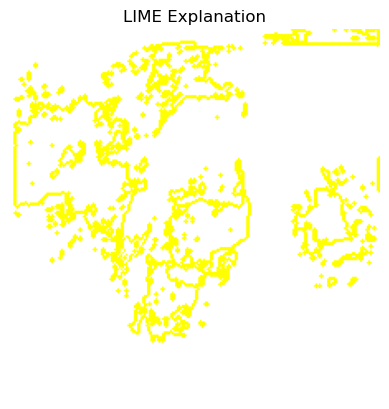

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the trained model (if not already loaded)
# model = load_model('my_densenet_model.h5')

# Define a function that returns model predictions in a LIME-compatible format
def predict_fn(images):
    processed_images = preprocess_input(images)
    predictions = model.predict(processed_images)
    return predictions

# Load and preprocess the image
image_path = 'D:\sample-backend\cancerous_image.jpg'
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Explain the model's prediction on the image
explanation = explainer.explain_instance(
    np.squeeze(img_array),  # The image
    predict_fn,             # Prediction function
    labels=(0, 1),          # Class labels for binary classification
    hide_color=0,
    num_samples=1000        # Number of perturbed samples to generate
)

# Show the explanation for the predicted class (you can change the index if necessary)
temp, mask = explanation.get_image_and_mask(
    label=0,              # You can specify class index (0 for benign, 1 for malignant, adjust accordingly)
    positive_only=False,
    num_features=10,       # Number of superpixels to highlight
    hide_rest=False
)

# Plot the LIME explanation
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")
plt.axis('off')
plt.show()
